# Анализ и прогнозирование оборота розничной торговли с использованием экспоненциального сглаживания

## Загрузка данных

In [1]:
import pandas as pd # Работа с табличными данными и рядами
import numpy as np # Работа с массивами
import statsmodels.api as sm # Анализ и моделирование временных рядов
import seaborn as sns # Визуализация
import matplotlib.pyplot as plt # Визуализация

# Графики встраиваются в блокнот:
%matplotlib inline
sns.set() # Стиль графиков

Для обработки табличных данных в Python используется пакет pandas. С тем, как выполнять базовые операции с таблицами и рядами pandas, можно познакомиться по блокнотам в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/pandas).

In [2]:
retail = pd.read_excel('retail.xlsx', # файл с данными
                       index_col='month',  # столбец 'month' нужно использовать как индекс
                       squeeze=True #нам нужен ряд, а не таблица
                      ) 

retail.index.freq='MS' # Уточнили частоту наблюдений - ежемесячно, для индекса используется 1й день месяца.
retail

month
1995-01-01      27.3
1995-02-01      28.1
1995-03-01      32.9
1995-04-01      33.4
1995-05-01      39.4
               ...  
2021-06-01    3189.0
2021-07-01    3288.8
2021-08-01    3419.4
2021-09-01    3391.8
2021-10-01    3462.4
Freq: MS, Name: RTRD_M, Length: 322, dtype: float64

Pandas поддерживает даты в качестве индекса, благодаря этому в этом пакете удобно обрабатывать временные ряды, т.к. выравнивание по дате, выполняется автоматически.

In [3]:
retail.index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01',
               ...
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', name='month', length=322, freq='MS')

Используя встроенные в pandas визуализации, посмотрим на данные. С визуализацией табличных данных в python можно познакомиться в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/EDA)

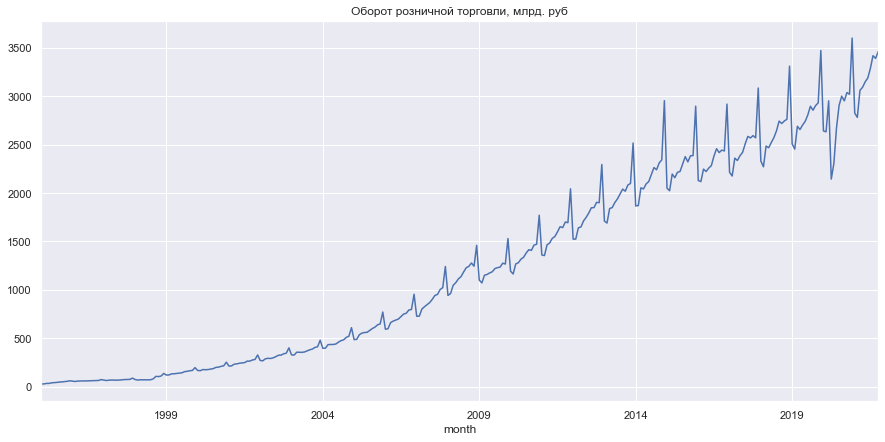

In [4]:
retail.plot(figsize=(15,7), title='Оборот розничной торговли, млрд. руб');

Данные есть за период с середины 1990-х. Для анализа возьмем последний период, когда закономерные компоненты ряда вели себя более-менее стабильно. Будем использовать данные с января 2010 года.

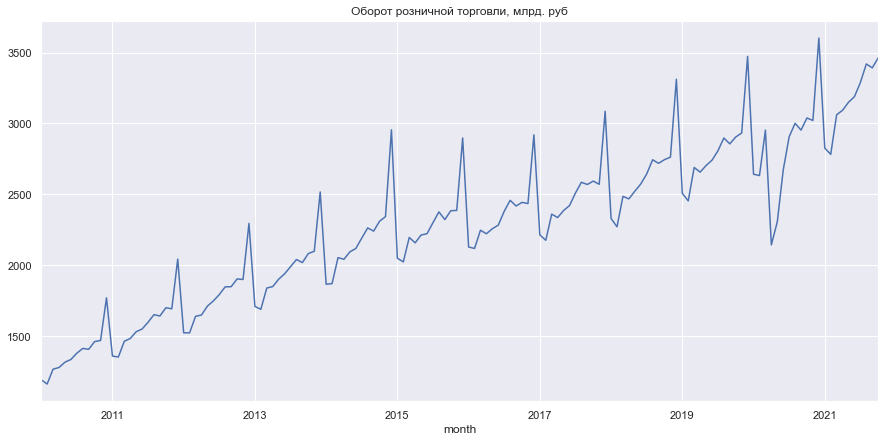

In [5]:
retail = retail['2010-01-01':] # в pandas можно задавать срезы по дате
retail.plot(figsize=(15,7), title='Оборот розничной торговли, млрд. руб');

На графике виден тренд и сезонность. Тип сезонности - мультипликативный.

## Моделирование

Полезные ресурсы и примеры:

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html  
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html  
https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/


Для проверки моделей разделим ряд на два подмножества, используя в качестве тестового множества последний год, а остальные данные - в качестве обучающего множества.

In [6]:
retail_train = retail[:'2020-10-01'] # Обучающее множество
retail_test = retail['2020-11-01':] # Тестовое множество

### Простое экспоненциальное сглаживание

Метод реализован с помощью класса [`SimpleExpSmoothing`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html) пакета statsmodels. 

См. также документацию на метод [`fit()`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit)

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Построим модель с заданной вручную константой сглаживания: $\alpha=0.1$.

In [8]:
retail_m_exp1 = SimpleExpSmoothing(retail_train, 
                               initialization_method="heuristic"
                              ).fit(smoothing_level=0.1, # Задаем константу сглаживания 0.1
                                    optimized=False)

In [9]:
retail_m_exp1.summary()

Dep. Variable:,RTRD_M,No. Observations:,130
Model:,SimpleExpSmoothing,SSE,7682162.807
Optimized:,False,AIC,1432.294
Trend:,None,BIC,1438.029
Seasonal:,None,AICC,1432.614
Seasonal Periods:,None,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
initial_level,1149.8267,l.0,False


In [10]:
retail_f_exp1 = retail_m_exp1.forecast(12) # прогноз на 12 месяцев
retail_fit_exp1 = retail_m_exp1.fittedvalues # прогноз модели в историческом периоде

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Построим еще одну модель с автоподбором константы сглаживания.

In [11]:
retail_m_exp2 = SimpleExpSmoothing(retail_train, 
                               initialization_method="heuristic"
                              ).fit(optimized=True # В этой модели константа подбирается автоматически
                                   )

In [12]:
retail_m_exp2.summary()

Dep. Variable:,RTRD_M,No. Observations:,130
Model:,SimpleExpSmoothing,SSE,6245197.980
Optimized:,True,AIC,1405.373
Trend:,None,BIC,1411.108
Seasonal:,None,AICC,1405.693
Seasonal Periods:,None,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2622945,alpha,True
initial_level,1265.5183,l.0,True


In [13]:
retail_m_exp2.params_formatted # Параметры модели

,name,param,optimized
smoothing_level,alpha,0.262294,True
initial_level,l.0,1265.518318,True


In [14]:
retail_f_exp2 = retail_m_exp2.forecast(12)
retail_fit_exp2 = retail_m_exp2.fittedvalues


W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


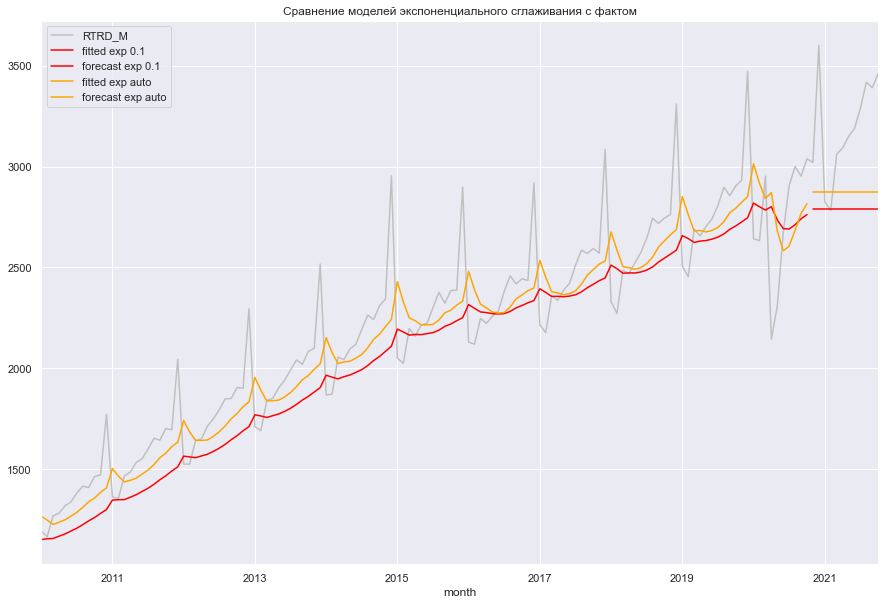

In [15]:
plt.subplots(figsize=(15, 10))
retail.plot(color='silver')
retail_fit_exp1.plot(label='fitted exp 0.1', color='red')
retail_f_exp1.plot(label='forecast exp 0.1', color='red')
retail_fit_exp2.plot(label='fitted exp auto', color='orange')
retail_f_exp2.plot(label='forecast exp auto', color='orange')
plt.title('Сравнение моделей экспоненциального сглаживания с фактом')
plt.legend();

Структура объекта модели:

In [16]:
str([S for S in dir(retail_m_exp1) if not S.startswith('_')])

"['aic', 'aicc', 'bic', 'data', 'fcastvalues', 'fittedfcast', 'fittedvalues', 'forecast', 'initialize', 'k', 'k_constant', 'level', 'mle_retvals', 'model', 'optimized', 'params', 'params_formatted', 'predict', 'resid', 'season', 'simulate', 'slope', 'sse', 'summary', 'trend']"

In [17]:
retail_m_exp1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.100000,False
initial_level,l.0,1149.826667,False


W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


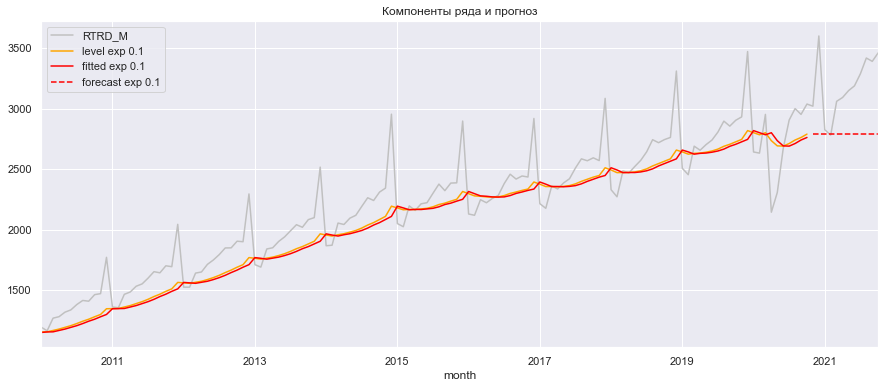

In [18]:
plt.subplots(figsize=(15, 6))
retail.plot(color='silver')
retail_m_exp1.level.plot(label='level exp 0.1', color='orange')
retail_m_exp1.fittedvalues.plot(label='fitted exp 0.1', color='red')
retail_m_exp1.forecast(12).plot(label='forecast exp 0.1', color='red', linestyle='dashed')
plt.title('Компоненты ряда и прогноз')
plt.legend();

## Метод Хольта

Метод Хольта реализован в классе [`ExponentialSmoothing`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)

В statsmodels есть также [альтернативная реализация метода Хольта](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html?highlight=holt).


In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Модель с константами сглаживания $\alpha=0.1$, $\beta=0.1$

In [20]:
retail_m_holt1 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive', # используется аддитивный тренд (линейный)
                               seasonal=None                                 
                              ).fit(smoothing_level=0.1, smoothing_trend=0.1, optimized=False)

In [21]:
retail_m_holt1.summary()

Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,5836616.453
Optimized:,False,AIC,1400.577
Trend:,Additive,BIC,1412.047
Seasonal:,None,AICC,1401.259
Seasonal Periods:,None,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
smoothing_trend,0.1000000,beta,False


In [22]:
retail_fit_holt1 = retail_m_holt1.fittedvalues
retail_f_holt1 = retail_m_holt1.forecast(12)


W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Модель с автоподбором констант

In [23]:
retail_m_holt2 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive',
                               seasonal=None                                 
                              ).fit(optimized=True)
retail_m_holt2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.099977,True
smoothing_trend,beta,0.076923,True
initial_level,l.0,1150.402826,True
initial_trend,b.0,19.968754,True


In [24]:
retail_fit_holt2 = retail_m_holt2.fittedvalues
retail_f_holt2 = retail_m_holt2.forecast(12)

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


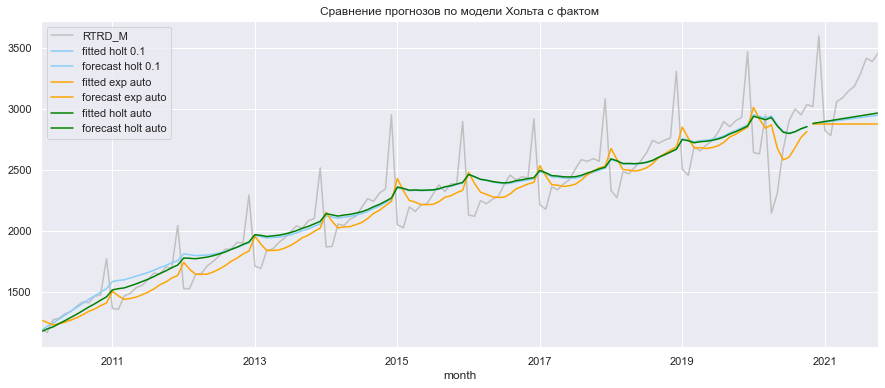

In [25]:
plt.subplots(figsize=(15, 6))
retail.plot(color='silver')
retail_fit_holt1.plot(label='fitted holt 0.1', color='lightskyblue')
retail_f_holt1.plot(label='forecast holt 0.1', color='lightskyblue')

retail_fit_exp2.plot(label='fitted exp auto', color='orange')
retail_f_exp2.plot(label='forecast exp auto', color='orange')

retail_fit_holt2.plot(label='fitted holt auto', color='green')
retail_f_holt2.plot(label='forecast holt auto', color='green')
plt.title('Сравнение прогнозов по модели Хольта с фактом')
plt.legend();

Извлечение параметров и компонентов

In [26]:
retail_m_holt1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.100000,False
smoothing_trend,beta,0.100000,False
initial_level,l.0,1149.826667,False
initial_trend,b.0,31.424242,False


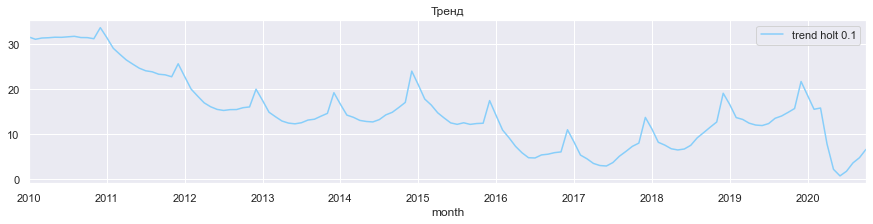

In [27]:
plt.subplots(figsize=(15, 3))

retail_m_holt1.trend.plot(label='trend holt 0.1', color='lightskyblue')

plt.legend()
plt.title('Тренд');



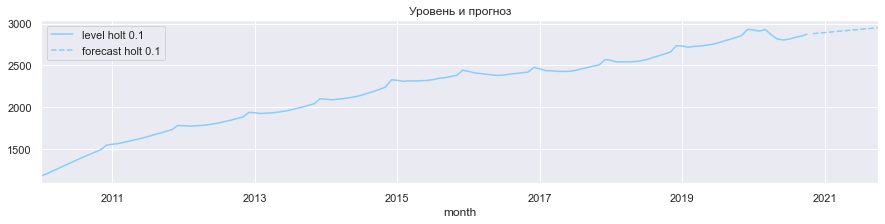

In [28]:
plt.subplots(figsize=(15, 3))

retail_m_holt1.level.plot(label='level holt 0.1', color='lightskyblue')
retail_f_holt1.plot(label='forecast holt 0.1', color='lightskyblue', linestyle='dashed')

plt.legend()
plt.title('Уровень и прогноз');

### Метод Винтерса

Метод Винтерса реализован с помощью класса [`ExponentialSmoothing`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)

Модель с константами сглаживания $\alpha=0.1$, $\beta=0.1$, $\gamma=0.1$.

In [29]:
retail_m_winters1 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive', #аддитивный тренд
                               seasonal='multiplicative', #мультипликативная сезонность                                  
                              ).fit(smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.1,
                                    optimized=False)

In [30]:
retail_m_winters1.summary()

Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,984412.154
Optimized:,False,AIC,1193.195
Trend:,Additive,BIC,1239.075
Seasonal:,Multiplicative,AICC,1199.357
Seasonal Periods:,12,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
smoothing_trend,0.1000000,beta,False


In [31]:
retail_m_winters1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.100000,False
smoothing_trend,beta,0.100000,False
smoothing_seasonal,gamma,0.100000,False
initial_level,l.0,1357.798056,False
initial_trend,b.0,17.787096,False
initial_seasons.0,s.0,0.908129,False
initial_seasons.1,s.1,0.895883,False
initial_seasons.2,s.2,0.963549,False
initial_seasons.3,s.3,0.958622,False
initial_seasons.4,s.4,0.978525,False


In [32]:
retail_fit_winters1 = retail_m_winters1.fittedvalues
retail_f_winters1 = retail_m_winters1.forecast(12)

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Модель с автоподбором констант.

In [33]:
retail_m_winters2 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive',
                               seasonal='multiplicative'                                 
                              ).fit(optimized=True)
retail_m_winters2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.606390,True
smoothing_trend,beta,0.000287,True
smoothing_seasonal,gamma,0.393049,True
initial_level,l.0,1356.386060,True
initial_trend,b.0,11.993529,True
initial_seasons.0,s.0,0.912640,True
initial_seasons.1,s.1,0.898011,True
initial_seasons.2,s.2,0.967478,True
initial_seasons.3,s.3,0.971834,True
initial_seasons.4,s.4,0.999790,True


In [34]:
retail_m_winters2.summary()

Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,807815.665
Optimized:,True,AIC,1167.492
Trend:,Additive,BIC,1213.373
Seasonal:,Multiplicative,AICC,1173.654
Seasonal Periods:,12,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6063898,alpha,True
smoothing_trend,0.0002870,beta,True


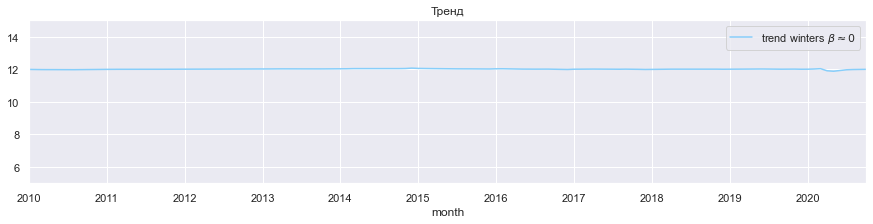

In [35]:
plt.subplots(figsize=(15, 3))

retail_m_winters2.trend.plot(label=r'trend winters $\beta \approx 0$', color='lightskyblue')

plt.ylim(5, 15)
plt.legend()

plt.title('Тренд');


In [36]:
retail_fit_winters2 = retail_m_winters2.fittedvalues
retail_f_winters2 = retail_m_winters2.forecast(12)

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


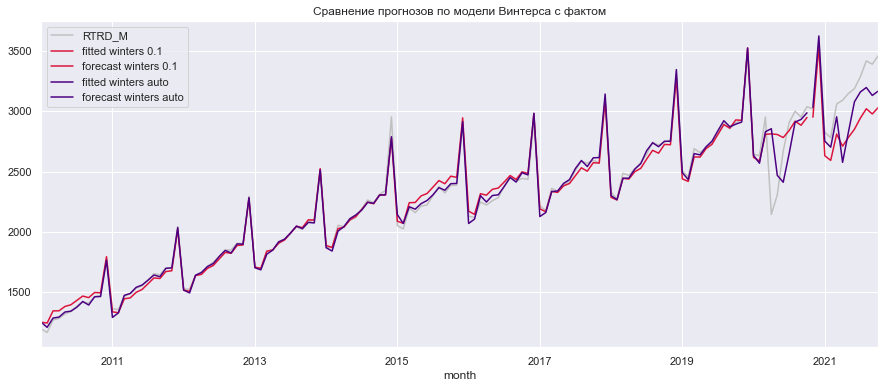

In [37]:
plt.subplots(figsize=(15, 6))

retail.plot(color='silver')
retail_fit_winters1.plot(label='fitted winters 0.1', color='crimson')
retail_f_winters1.plot(label='forecast winters 0.1', color='crimson')

retail_fit_winters2.plot(label='fitted winters auto', color='indigo')
retail_f_winters2.plot(label='forecast winters auto', color='indigo')
plt.title('Сравнение прогнозов по модели Винтерса с фактом')

plt.legend();

## Расчет ошибок

В statsmodels реализованы несколько [показателей ошибки прогноза](https://www.statsmodels.org/dev/tools.html?highlight=eval#measure-for-fit-performance-eval-measures)

In [38]:
from statsmodels.tools.eval_measures import rmse, bias, meanabs

In [39]:
rmse(retail_test, retail_f_winters2)

227.55921592940487

In [40]:
bias(retail_test, retail_f_winters2)

172.14326389492666

In [41]:
meanabs(retail_f_winters2, retail_test)

178.38298027590963

Однако, среди реализованных показателей нет MAPE, поэтому реализуем функцию для расчета MAPE самостоятельно:

In [42]:
mape = lambda actuals, forecast : ((actuals - forecast).abs() / actuals).mean()

In [43]:
mape(retail_test, retail_f_winters2)

0.055568117686140533

Для удобства сравнения моделей, создадим свою функцию, которая принимает ряды с фактом и прогнозом и возвращает показатели ошибки в табличном виде:

In [44]:
def metrics(model, actuals, forecast):
    return pd.DataFrame({'model' : model, 
                         'mape' : mape(actuals, forecast),
                         'rmse' : rmse(actuals, forecast),
                         'bias' : bias(actuals, forecast)
                        }, index = [1])

In [45]:
metrics('Простое эксп. сглаживание, 0.1', retail_test, retail_f_exp1)

,model,mape,rmse,bias
1,"Простое эксп. сглаживание, 0.1",0.120882,467.811576,400.495306


Используем функцию, чтобы сравнить и ранжировать построенные модели по ошибке MAPE

In [46]:
compare = metrics('Простое эксп. сглаживание, 0.1', retail_test, retail_f_exp1)
compare = compare.append(metrics('Простое эксп. сглаживание, авто', retail_test, retail_f_exp2), ignore_index=True )
compare = compare.append(metrics('Хольт, 0.1', retail_test, retail_f_holt1), ignore_index=True)
compare = compare.append(metrics('Хольт, авто', retail_test, retail_f_holt2), ignore_index=True)
compare = compare.append(metrics('Винтерс, 0.1', retail_test, retail_f_winters1), ignore_index=True)
compare = compare.append(metrics('Винтерс, авто', retail_test, retail_f_winters2), ignore_index=True)
compare.sort_values(by='mape')


,model,mape,rmse,bias
5,"Винтерс, авто",0.055568,227.559216,172.143264
4,"Винтерс, 0.1",0.089206,312.183345,286.116435
3,"Хольт, авто",0.089650,350.348842,264.849904
2,"Хольт, 0.1",0.092175,359.794126,275.679248
1,"Простое эксп. сглаживание, авто",0.102101,397.727913,315.810564
0,"Простое эксп. сглаживание, 0.1",0.120882,467.811576,400.495306


## Модели с затухающим и экспоненциальным трендом

Модель с экспоненциальным трендом

In [47]:
retail_m_holt3 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='multiplicative',
                               seasonal=None                                 
                              ).fit(optimized=True)
retail_m_holt3.summary()

Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,6126018.137
Optimized:,True,AIC,1406.868
Trend:,Multiplicative,BIC,1418.338
Seasonal:,None,AICC,1407.551
Seasonal Periods:,None,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1228571,alpha,True
smoothing_trend,0.1146667,beta,True


W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


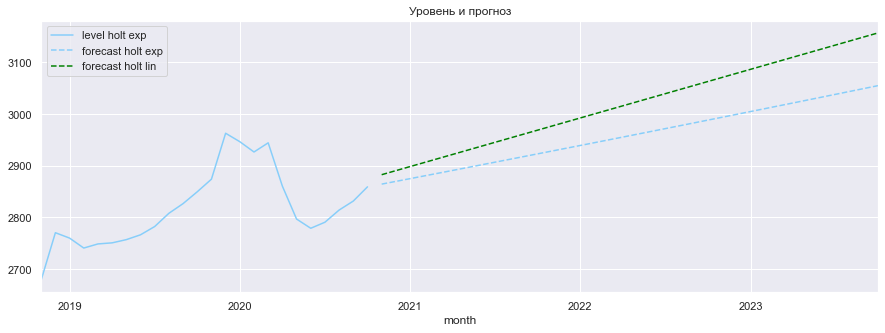

In [48]:
plt.subplots(figsize=(15, 5))

retail_m_holt3.level[-24:].plot(label='level holt exp', color='lightskyblue')
retail_m_holt3.forecast(36).plot(label='forecast holt exp', color='lightskyblue', linestyle='dashed')
retail_m_holt2.forecast(36).plot(label='forecast holt lin', color='green', linestyle='dashed')

plt.legend()
plt.title('Уровень и прогноз');

Аддитивный затухающий тренд

In [49]:
retail_m_holt4 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive',
                               damped=True,
                               seasonal=None                                 
                              ).fit(optimized=True)
retail_m_holt4.summary()

C:\Users\bitopfer\AppData\Local\Temp/ipykernel_18596/3161774516.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  retail_m_holt4 = ExponentialSmoothing(retail_train,


Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,5414854.383
Optimized:,True,AIC,1392.826
Trend:,Additive,BIC,1407.164
Seasonal:,None,AICC,1393.744
Seasonal Periods:,None,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0518269,alpha,True
smoothing_trend,0.0512985,beta,True


In [50]:
retail_m_holt5 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='multiplicative',
                               damped=True,
                               seasonal=None                                 
                              ).fit(optimized=True)
retail_m_holt5.summary()

C:\Users\bitopfer\AppData\Local\Temp/ipykernel_18596/500700412.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  retail_m_holt5 = ExponentialSmoothing(retail_train,


Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,5939403.159
Optimized:,True,AIC,1404.846
Trend:,Multiplicative,BIC,1419.184
Seasonal:,None,AICC,1405.764
Seasonal Periods:,None,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0992857,alpha,True
smoothing_trend,0.0916484,beta,True


W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


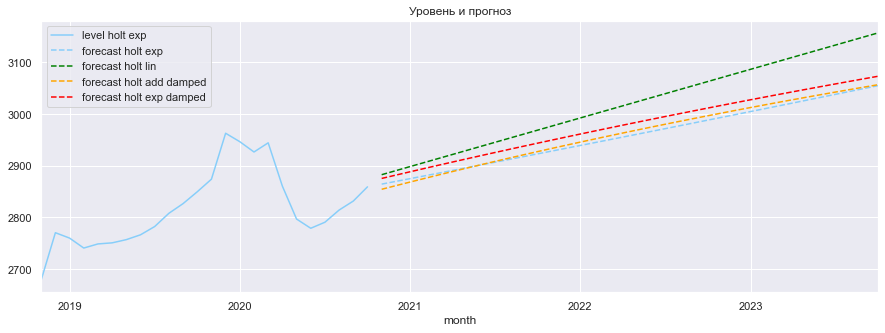

In [51]:
plt.subplots(figsize=(15, 5))

retail_m_holt3.level[-24:].plot(label='level holt exp', color='lightskyblue')
retail_m_holt3.forecast(36).plot(label='forecast holt exp', color='lightskyblue', linestyle='dashed')
retail_m_holt2.forecast(36).plot(label='forecast holt lin', color='green', linestyle='dashed')
retail_m_holt4.forecast(36).plot(label='forecast holt add damped', color='orange', linestyle='dashed')
retail_m_holt5.forecast(36).plot(label='forecast holt exp damped', color='red', linestyle='dashed')

plt.legend()
plt.title('Уровень и прогноз');

### Модели Винтерса с нелинейными трендами

In [52]:
retail_m_winters3 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='multiplicative',
                               seasonal='multiplicative'                                 
                              ).fit(optimized=True)
retail_m_winters3.summary()

W:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,833385.313
Optimized:,True,AIC,1171.543
Trend:,Multiplicative,BIC,1217.424
Seasonal:,Multiplicative,AICC,1177.705
Seasonal Periods:,12,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6060732,alpha,True
smoothing_trend,0.0275514,beta,True


In [53]:
retail_m_winters4 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive', damped=True,                                         
                               seasonal='multiplicative'                                 
                              ).fit(optimized=True)
retail_m_winters4.summary()

C:\Users\bitopfer\AppData\Local\Temp/ipykernel_18596/867289802.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  retail_m_winters4 = ExponentialSmoothing(retail_train,


Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,808070.531
Optimized:,True,AIC,1169.533
Trend:,Additive,BIC,1218.281
Seasonal:,Multiplicative,AICC,1176.442
Seasonal Periods:,12,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6061207,alpha,True
smoothing_trend,0.0001018,beta,True


In [54]:
retail_m_winters5 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='multiplicative', damped=True,
                               seasonal='multiplicative'                                 
                              ).fit(optimized=True)
retail_m_winters5.summary()

C:\Users\bitopfer\AppData\Local\Temp/ipykernel_18596/4260076761.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  retail_m_winters5 = ExponentialSmoothing(retail_train,


Dep. Variable:,RTRD_M,No. Observations:,130
Model:,ExponentialSmoothing,SSE,810342.185
Optimized:,True,AIC,1169.898
Trend:,Multiplicative,BIC,1218.646
Seasonal:,Multiplicative,AICC,1176.807
Seasonal Periods:,12,Date:,"Thu, 10 Mar 2022"
Box-Cox:,False,Time:,08:46:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5707144,alpha,True
smoothing_trend,0.0001001,beta,True


W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


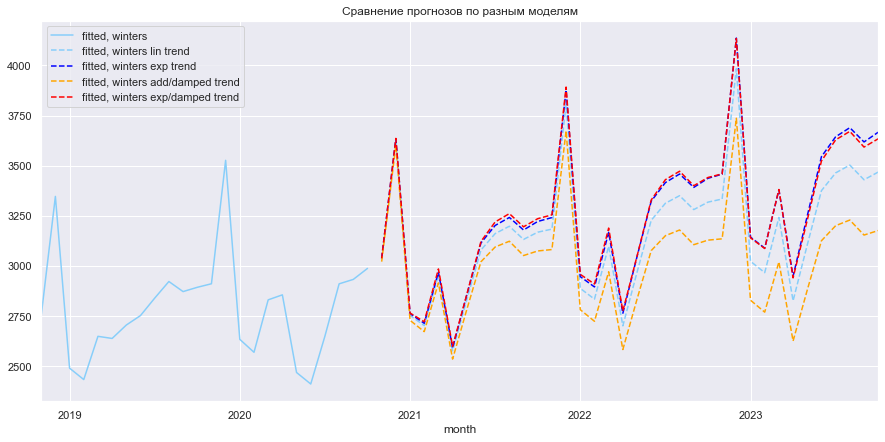

In [55]:
plt.subplots(figsize=(15, 7))

retail_m_winters2.fittedvalues[-24:].plot(label='fitted, winters', color='lightskyblue')
retail_m_winters2.forecast(36).plot(label='fitted, winters lin trend', color='lightskyblue', linestyle='dashed')
retail_m_winters3.forecast(36).plot(label='fitted, winters exp trend', color='blue', linestyle='dashed')
retail_m_winters4.forecast(36).plot(label='fitted, winters add/damped trend', color='orange', linestyle='dashed')
retail_m_winters5.forecast(36).plot(label='fitted, winters exp/damped trend', color='red', linestyle='dashed')

plt.legend()
plt.title('Сравнение прогнозов по разным моделям');

In [56]:
compare = metrics('Винтерс, 0.1', retail_test, retail_f_winters1)
compare = compare.append(metrics('Винтерс, авто', retail_test, retail_f_winters2), ignore_index=True)
compare = compare.append(metrics('Винтерс, эксп тренд', retail_test, retail_m_winters3.forecast(12)), ignore_index=True)
compare = compare.append(metrics('Винтерс, аддит/зат тренд', retail_test, retail_m_winters4.forecast(12)), ignore_index=True)
compare = compare.append(metrics('Винтерс, эксп/зат тренд', retail_test, retail_m_winters5.forecast(12)), ignore_index=True)
compare.sort_values(by='mape')

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,model,mape,rmse,bias
4,"Винтерс, эксп/зат тренд",0.045572,197.269304,137.211625
2,"Винтерс, эксп тренд",0.048400,204.914468,146.627677
1,"Винтерс, авто",0.055568,227.559216,172.143264
3,"Винтерс, аддит/зат тренд",0.069050,274.818169,221.631036
0,"Винтерс, 0.1",0.089206,312.183345,286.116435


## ETS

https://www.statsmodels.org/devel/examples/notebooks/generated/ets.html

In [57]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [58]:
retail_m_ets1 = ETSModel(
    retail_train,
    error="additive",
    trend="additive",
    seasonal="multiplicative",
    damped_trend=True,
    seasonal_periods=12,
).fit()

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


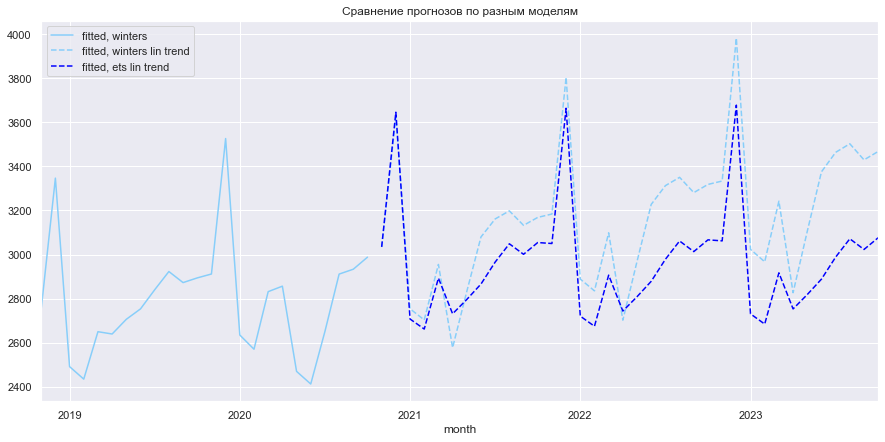

In [59]:
plt.subplots(figsize=(15, 7))

retail_m_winters2.fittedvalues[-24:].plot(label='fitted, winters', color='lightskyblue')
retail_m_winters2.forecast(36).plot(label='fitted, winters lin trend', color='lightskyblue', linestyle='dashed')
retail_m_ets1.forecast(36).plot(label='fitted, ets lin trend', color='blue', linestyle='dashed')

plt.legend()
plt.title('Сравнение прогнозов по разным моделям');

In [60]:
retail_m_ets1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                 RTRD_M   No. Observations:                  130
Model:                      ETS(AAdM)   Log Likelihood                -749.002
Date:                Thu, 10 Mar 2022   AIC                           1536.005
Time:                        08:46:08   BIC                           1590.488
Sample:                    01-01-2010   HQIC                          1558.143
                         - 10-01-2020   Scale                         5914.944
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.128      7.793      0.000       0.748       1.251
smoothing_trend      9.999e-05      0.018      0.005      0.996      -0.036       0.036
smoothing_seasonal   8.211e-05        nan        nan        nan         nan         nan
damping_trend           0.9800        nan        nan        nan         nan         nan
initial_level        1357.7934        nan        nan        nan         nan         nan
initial_trend          17.7952     16.667      1.068      0.286     -14.872      50.462
initial_seasonal.0      1.3478        nan        nan        nan         nan         nan
initial_seasonal.1      1.1221        nan        nan        nan         nan         nan
initial_seasonal.2      1.1242        nan        nan        nan         nan         nan
initial_seasonal.3      1.1049        nan        nan        nan         nan         nan
initial_seasonal.4      1.1229        nan        nan        nan         nan         nan
initial_seasonal.5      1.0928        nan        nan        nan         nan         nan
initial_seasonal.6      1.0564        nan        nan        nan         nan         nan
initial_seasonal.7      1.0310        nan        nan        nan         nan         nan
initial_seasonal.8      1.0074        nan        nan        nan         nan         nan
initial_seasonal.9      1.0677        nan        nan        nan         nan         nan
initial_seasonal.10     0.9827        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       19.09   Jarque-Bera (JB):              8456.68
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               7.92   Skew:                            -4.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [61]:
retail_f_ets1 = retail_m_ets1.get_prediction(end="2023")
retail_f_ets1.summary_frame(alpha=0.05)

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,mean,mean_numerical,pi_lower,pi_upper
2010-01-01,1375.232684,1373.821301,1223.567024,1518.476634
2010-02-01,1189.803602,1193.302256,1040.633471,1347.217984
2010-03-01,1282.397522,1283.842768,1131.781449,1431.913459
2010-04-01,1213.126000,1210.186399,1050.560799,1355.245846
2010-05-01,1326.848742,1325.221482,1176.176132,1477.078592
...,...,...,...,...
2022-09-01,3013.215774,3017.522305,2324.081043,3748.190412
2022-10-01,3066.626984,3074.800804,2364.634459,3826.076709
2022-11-01,3061.945729,3071.448600,2359.366847,3835.398720
2022-12-01,3678.669703,3688.343661,2803.291056,4590.002365
